# // Getting NFL Data
___
The first step in getting this project underway is going to be getting **massive** amounts of NFL data from the web. I will be working in this notebook to "show my work" and for others to learn how to if they're curious. Ultimately, I'll also turn it into a regular `.py` Python script that you can run if you're so inclined.

For that, we're going to use the `requests` and `BeautifulSoup` libraries as well as API calls to glean information from:

- [Pro Football Reference](https://www.pro-football-reference.com/)
- [FFToday](http://www.fftoday.com/stats/)
- [The Football Database](https://www.footballdb.com/fantasy-football/index.html)

In [1]:
# Importing our necessary libraries
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests

from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
%matplotlib inline

## Let's start with FFToday
I'm choosing to go with this one first for the following reasons:
- Need to register for free
- Looking at .5 PPR scoring
- The Football Database seemed like it was missing quite a few players from each week

Setting up the scraping for **one position** iteration of our scrape:

1. Making an empty `dataframe` to throw our scrape into:

In [76]:
qbs_df = pd.DataFrame(columns= ['player', 'team', 'week', 'pass_comp',
                                'pass_att', 'pass_yds', 'pass_TD', 'pass_INT',
                                'rush_att', 'rush_yds', 'rush_TD', 'fpoints'])
qbs_df

,player,team,week,pass_comp,pass_att,pass_yds,pass_TD,pass_INT,rush_att,rush_yds,rush_TD,fpoints


2. Making some empty `lists` to fill with stats:

In [77]:
player = []
team = []
week = []
pass_comp = []
pass_att = []
pass_yds = []
pass_TD = []
pass_INT = []
rush_att = []
rush_yds = []
rush_TD = []
fpoints = []

In [78]:
qb_columns_lists = [player, team, week, pass_comp, pass_att, pass_yds, pass_TD, pass_INT, 
                    rush_att, rush_yds, rush_TD, fpoints]

3. Doing the actual scrape by going through each week of the season (via each URL iteration), grabbing the right `table`, iterating through each `row` and then `cell`, and putting that data into the appropriate `lists`.

In [79]:
res = requests.get('http://www.fftoday.com/stats/playerstats.php?Season=2018&GameWeek=1&PosID=10&LeagueID=193033')
soup = BeautifulSoup(res.content, 'lxml')


for number in range(1,5):
    res = requests.get('http://www.fftoday.com/stats/playerstats.php?Season=2018&GameWeek={}&PosID=10&LeagueID=193033'.format(number))
    soup = BeautifulSoup(res.content, 'lxml')
    for row in soup.find('table', {'cellpadding':2}).find_all('tr')[2:]:
        cells = row.find_all('td')
        for index, selection in enumerate(qb_columns_lists):
            selection.append(cells[index].text.strip())
        # The "week" column from our website is actually always 1, and I'm not sure what it does
        # I want "week" to become a unique identifier to bring in opponents
        week.pop()
        week.append(number)

4. Cleaning up a little kerfuffle in the `player` column.

In [81]:
player = [individual[3:].lstrip() for individual in player]
qb_columns_lists[0] = player

5. Filling our `dataframe` with all of the appropriate `lists`.

In [82]:
for index, column in enumerate(qbs_df.columns):
    qbs_df[str(column)] = qb_columns_lists[index]

In [83]:
qbs_df.head()

,player,team,week,pass_comp,pass_att,pass_yds,pass_TD,pass_INT,rush_att,rush_yds,rush_TD,fpoints
0,Ryan Fitzpatrick,TB,1,21,28,417,4,0,12,36,1,42.3
1,Drew Brees,NO,1,37,45,439,3,0,0,0,0,29.6
2,Philip Rivers,LAC,1,34,51,424,3,1,0,0,0,29.0
3,Patrick Mahomes,KC,1,15,27,256,4,0,5,21,0,28.3
4,Tyrod Taylor,CLE,1,15,40,197,1,1,8,77,1,25.6


- Spot checking with a single player:

In [84]:
qbs_df[qbs_df['player'] == 'Tom Brady']

,player,team,week,pass_comp,pass_att,pass_yds,pass_TD,pass_INT,rush_att,rush_yds,rush_TD,fpoints
8,Tom Brady,NE,1,26,39,277,3,1,1,2,0,23.3
52,Tom Brady,NE,2,24,35,234,2,0,3,10,0,18.4
98,Tom Brady,NE,3,14,26,133,1,1,1,2,0,9.5
119,Tom Brady,NE,4,23,35,274,3,2,0,0,0,23.0


6. Alright! Looking like what we've got so far is working! Except...

In [88]:
qbs_df.dtypes

player       object
team         object
week          int64
pass_comp    object
pass_att     object
pass_yds     object
pass_TD      object
pass_INT     object
rush_att     object
rush_yds     object
rush_TD      object
fpoints      object
dtype: object

In [90]:
for col in qbs_df.columns[2:]:
    qbs_df[col] = qbs_df[col].astype(float)

In [91]:
qbs_df.dtypes

player        object
team          object
week         float64
pass_comp    float64
pass_att     float64
pass_yds     float64
pass_TD      float64
pass_INT     float64
rush_att     float64
rush_yds     float64
rush_TD      float64
fpoints      float64
dtype: object

#### Woohoo! Looking like we're good there for now (for one position and with very basic info). Let's mess around with some vizzes!

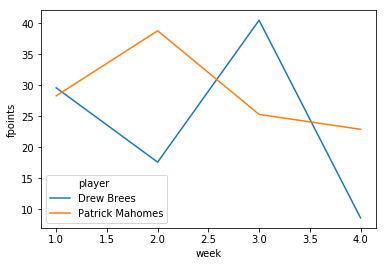

In [100]:
sns.lineplot(x="week", y="fpoints", data=qbs_df[(qbs_df.player == 'Drew Brees') | (qbs_df.player == 'Patrick Mahomes')], hue='player');